<h1 align="center" style="background-color:#616161;color:white">When do people listen to music?</h1>

In [218]:
# import modules
%matplotlib inline
import os
import sys
import numpy as np
import pandas as pd
import datetime
import time
import csv
import json
import sqlite3
from pathlib import Path
from sklearn.manifold import TSNE
from sklearn.datasets import fetch_20newsgroups
import matplotlib.pyplot as plt
import gensim, logging
from ggplot import *

## Parameters you can change

# Abs path to settings file
root = "C:/DS/Github/MusicRecommendation"  # BA, Windows
#root = "/home/badrul/Documents/github/MusicRecommendation" # BA, Linux

## Import the codebase module
fPath = root + "/1_codemodule"
if fPath not in sys.path: sys.path.append(fPath)

import coreCode as cb
import lastfmCode as fm

## Finish setting up
os.chdir(root)

settingsDict =  cb.loadSettings()

dbPath = root + settingsDict['mainDbPath']
fmSimilarDbPath = root + settingsDict['fmSimilarDbPath']
fmTagsDbPath = root + settingsDict['fmTagsDbPath']
trackMetaDbPath = root + settingsDict['trackmetadata']


<h3 style="background-color:#616161;color:white">0. Defining 'start' of a listening session</h3>

In [219]:
# Start of a new listening session is defined as when the interval in minutes since the previous listening time is
# greater than this number. Adjust as necessary, will be used for the remainder of the abalysis
NewSessIntervalTime = 10

<h3 style="background-color:#616161;color:white">1. Overall picture of when people start listening to music</h3>

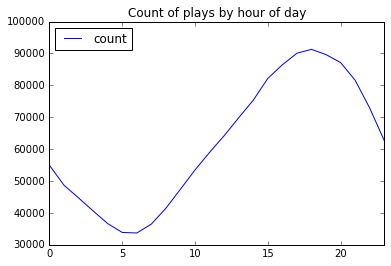

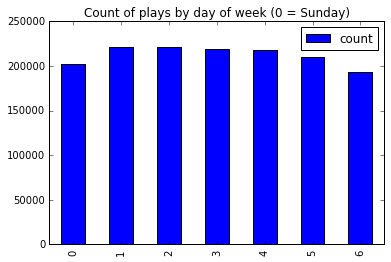

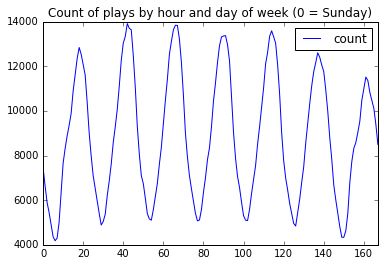

In [220]:
# Read sqlite query results into a pandas DataFrame
con = sqlite3.connect(dbPath)
hours = pd.read_sql_query("Select strftime('%H',PlayedTimestamp) as hourOfWeek, count(PlayedTimestamp)  as count  from tblMain where MinsSincePrevPlay > {} group by hourOfWeek".format(NewSessIntervalTime), con)
week = pd.read_sql_query("Select strftime('%w',PlayedTimestamp) as hourOfWeek, count(PlayedTimestamp)  as count  from tblMain where MinsSincePrevPlay > {} group by hourOfWeek".format(NewSessIntervalTime), con)
hrwk = pd.read_sql_query("Select strftime('%w',PlayedTimestamp) || '-' || strftime('%H',PlayedTimestamp) as timeSlot, count(PlayedTimestamp)  as count  from tblMain where MinsSincePrevPlay > {} group by timeSlot".format(NewSessIntervalTime), con)
con.close()

hours.plot(title='Count of plays by hour of day')
week.plot.bar(title='Count of plays by day of week (0 = Sunday)')
hrwk.plot(title='Count of plays by hour and day of week (0 = Sunday)')

<b>Conclusion</b>

* People listen to music more during the week than on weekends
* There is a predictable pattern to the time of day that people listen to music, at leasat at this aggregate level
* Daytime hours are the most popular time to listen to music, peaking in the early evening / after-work hours

<h3 style="background-color:#616161;color:white">3. Now let's do user level analysis</h3>

In [221]:
import time

con = sqlite3.connect(dbPath)
con.row_factory = sqlite3.Row
cursor = con.cursor()

sqlStr = "Select UserID, strftime('%w',PlayedTimestamp) || '-' || strftime('%H',PlayedTimestamp) as TimeSlot, count(PlayedTimestamp)  as StartCount  from tblMain where MinsSincePrevPlay > {} group by UserID, TimeSlot".format(NewSessIntervalTime)
df = pd.read_sql_query(sqlStr, con)

con.close()

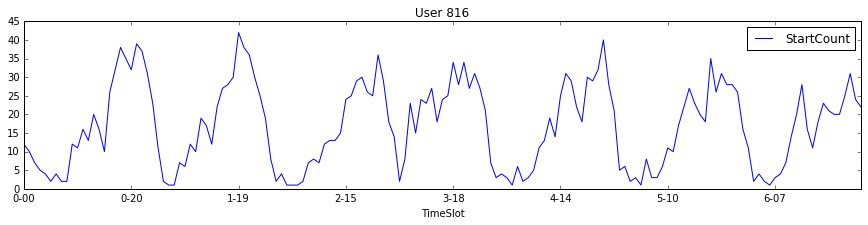

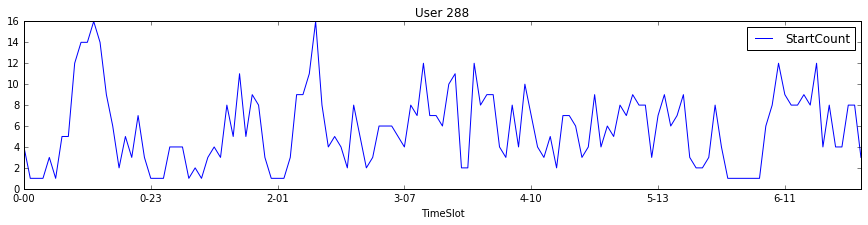

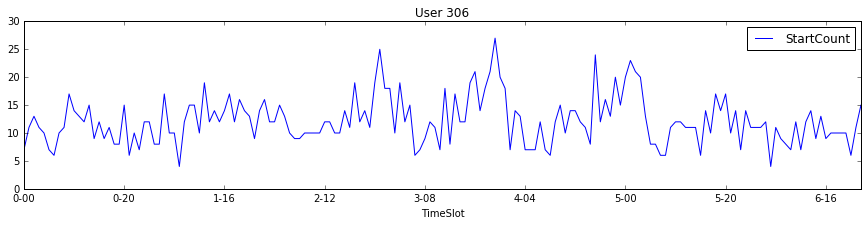

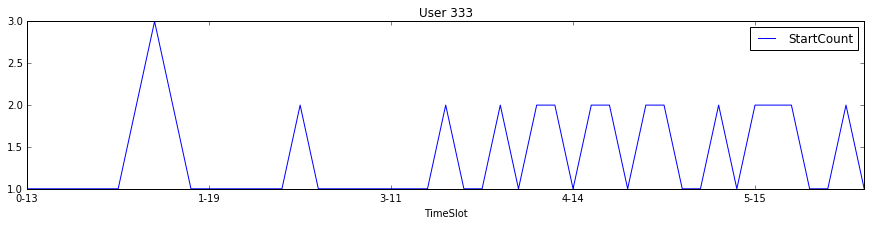

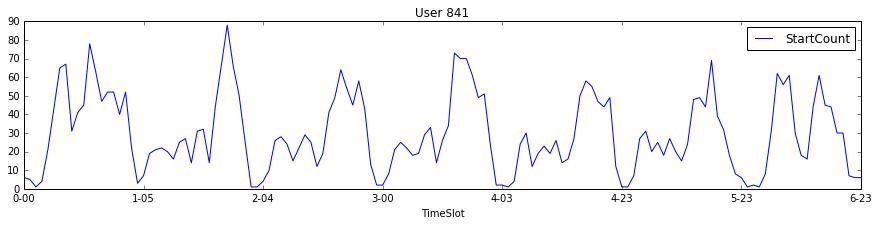

In [222]:
import random
userIDs = random.sample(range(1, 1000), 4)  # Select 4 random userIDs
#or
userIDs = [816,288,306,333,841]

for i in userIDs:
    d = df[df.UserID == i]
    d.plot(x='TimeSlot', y='StartCount', title = 'User {}'.format(i),figsize=[15,3])

As we can see from this small sample , while most users do tend to have specific times of during the week they tend to listen to music, for some users such as user 306 there is quite a bit of variance.

<h4 style="background-color:#616161;color:white">How many weeks before users demonstrate a pattern?</h4>

In [231]:
import time

con = sqlite3.connect(dbPath)
con.row_factory = sqlite3.Row
cursor = con.cursor()

HistIDMax = 2000

sqlStr = "Select UserID, strftime('%d-%m-%Y',PlayedTimestamp) as PlayedDate, strftime('%w',PlayedTimestamp) || '-' || strftime('%H',PlayedTimestamp) as TimeSlot, count(PlayedTimestamp)  as StartCount  from tblMain where MinsSincePrevPlay > {} and HistoryID <= {} group by UserID, PlayedTimestamp, TimeSlot".format(NewSessIntervalTime,HistIDMax)
df = pd.read_sql_query(sqlStr, con)
con.close()

In [232]:
df['CCount'] = df.groupby(['UserID','TimeSlot'])['StartCount'].cumcount()+1
df['SCount'] = df.groupby(['UserID'])['StartCount'].cumcount()+1

In [233]:
df.head()

,UserID,PlayedDate,TimeSlot,StartCount,CCount,SCount
0,1,13-08-2006,0-14,1,1,1
1,1,15-08-2006,2-12,1,1,2
2,1,15-08-2006,2-13,1,1,3
3,1,15-08-2006,2-14,1,1,4
4,1,16-08-2006,3-10,1,1,5


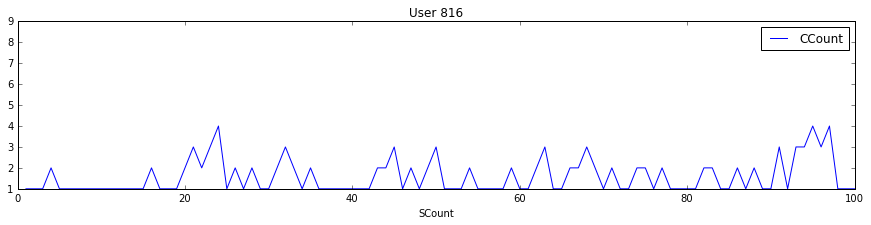

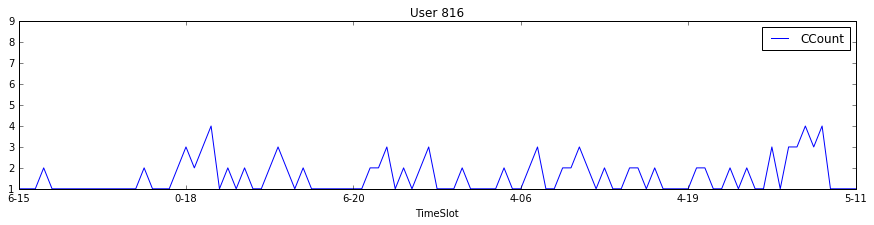

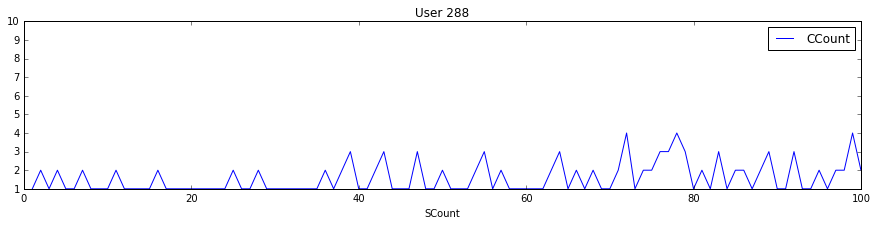

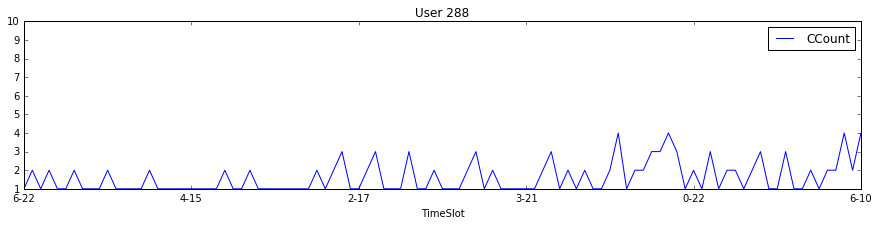

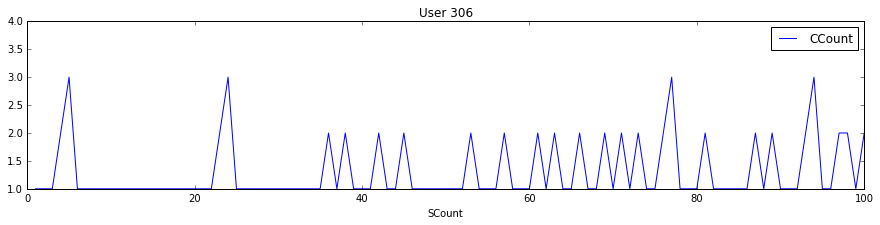

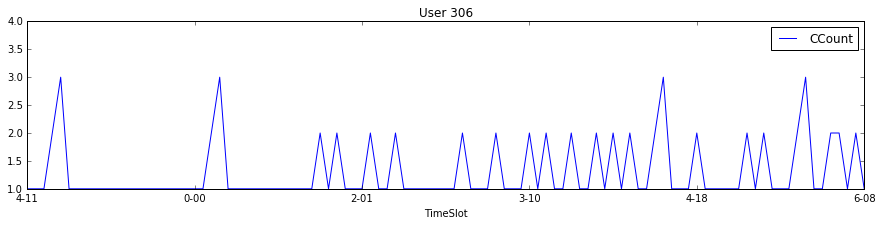

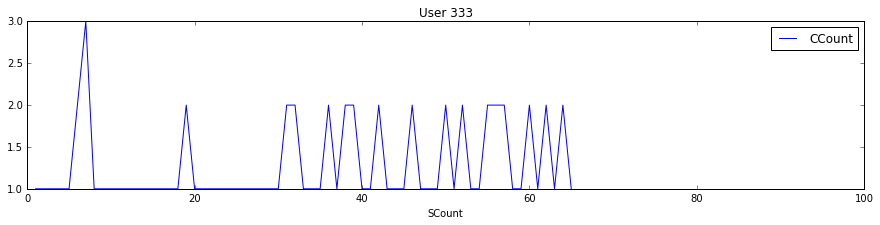

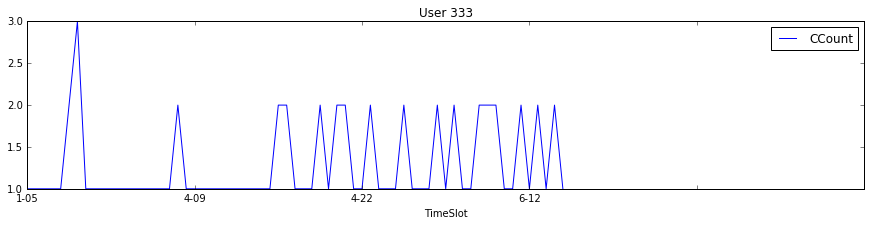

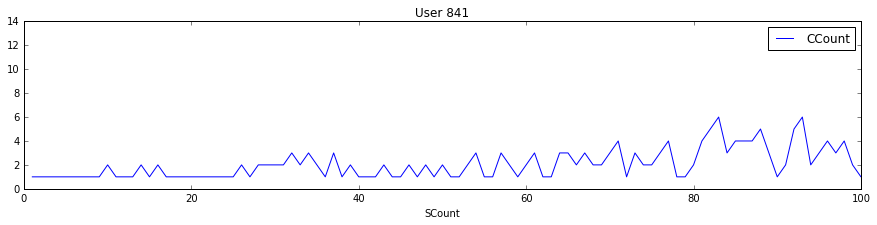

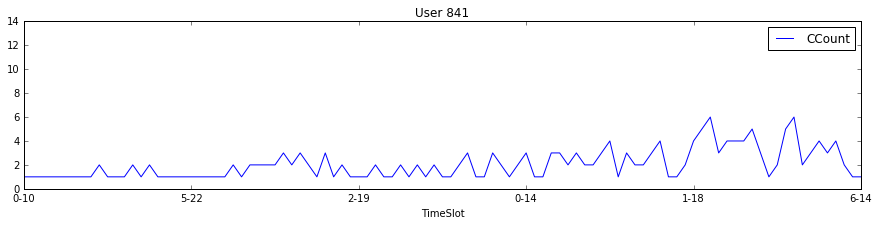

In [236]:
from ggplot import *
userIDs = random.sample(range(1, 1000), 4)  # Select 4 random userIDs
#or
userIDs = [816,288,306,333,841]

for i in userIDs:
    d = df[df.UserID == i]
    d.plot(x='SCount', y='CCount', title ='User {}'.format(i),figsize=[15,3],xlim=[0,100])
    ax=d.plot(x='TimeSlot', y='CCount', title ='User {}'.format(i),figsize=[15,3],xlim=[0,100])
    
#p = ggplot(d,aes(x='SCount', y='CCount'))  + geom_line() #+ facet_wrap("UserID")
#p

<h3 style="background-color:#616161;color:white">2. Construct a frequency table in the db on when users start listening to music</h3>

In [227]:
con = sqlite3.connect(dbPath)
con.row_factory = sqlite3.Row
cursor = con.cursor()
# Perform sql query to bring back the right results, use pandas to pivot to the right form, then save back into db
sqlStr = "Select UserID, strftime('%w',PlayedTimestamp) || '-' || strftime('%H',PlayedTimestamp) as TimeSlot, count(PlayedTimestamp)  as count  from tblMain where MinsSincePrevPlay > {} group by TimeSlot, UserID".format(NewSessIntervalTime)
df = pd.read_sql_query(sqlStr, con)
df=df.set_index('UserID')
#df=df.pivot(index='UserID', columns='TimeSlot', values='count')
df.to_sql('tblPlayTimetable',con,if_exists='replace')

con.close()

<h3 style="background-color:#616161;color:white">3. Check our newly constructed PlayTimetable agrees with section 1</h3>

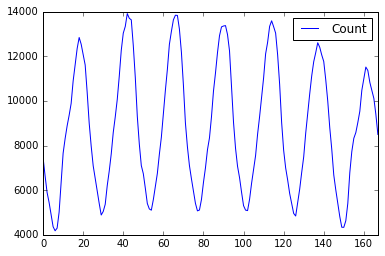

In [228]:
# Read sqlite query results into a pandas DataFrame
con = sqlite3.connect(dbPath)
df = pd.read_sql_query("SELECT TimeSlot, sum(Count) as Count from tblPlayTimetable group by Timeslot", con)
con.close()

#total = df['Count','TimeSlot'].groupby(['TimeSlot']).sum()
df.plot()

<h3 style="background-color:#616161;color:white">4. User level analysis</h3>

In [229]:
# Read sqlite query results into a pandas DataFrame
con = sqlite3.connect(dbPath)
df = pd.read_sql_query("SELECT UserID, TimeSlot, sum(Count) as Count from tblPlayTimetable group by UserID, TimeSlot", con)
con.close()
df.set_index('TimeSlot', inplace=True)  #inplace means modify this df

<h4 style="background-color:#616161;color:white">User Level Frequency</h4>

(0, 80)

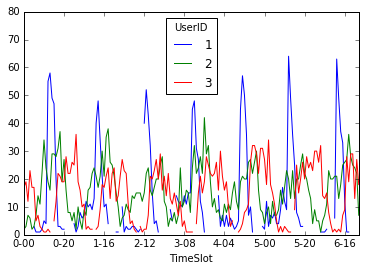

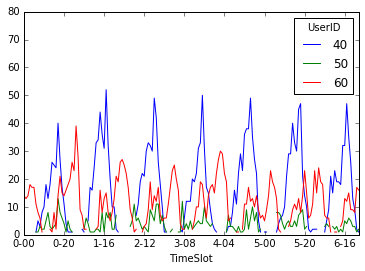

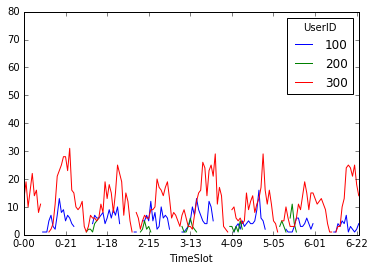

In [230]:
userList = [1,2,3]
df2 = df.loc[df['UserID'].isin(userList)]
df2 = df2.pivot(columns='UserID', values='Count')
ax1 = df2.plot()
ax1.set_ylim(0,80)

userList = [40,50,60]
df2 = df.loc[df['UserID'].isin(userList)]
df2 = df2.pivot(columns='UserID', values='Count')
ax2 = df2.plot()
ax2.set_ylim(0,80)

userList = [100,200,300]
df2 = df.loc[df['UserID'].isin(userList)]
df2 = df2.pivot(columns='UserID', values='Count')
ax2 = df2.plot()
ax2.set_ylim(0,80)

It does appear that the average listening time for individual users follows a predictable pattern, even if the amount they listens varies. Let's do a more conclusive test by assesing the standard deviation by user by timeslot

<b>What this chart shows</b>
* Data was grouped by how many times users started listening to music in each hour
* 'Started listening to' was defined as where there was a 10 minute gap before they last listened
* The count was then averaged up for each user across their entire play history and this is the mean line shown in the boxplot
* The bars around the mean show how much the count varied by on average
* We see that the early evening hours are the most popular time to listen to music but it also has the most variance